In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer

c:\Users\79217\Documents\TUD\3 semester\LLM\SemEval\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "./public_data/train/track_a/eng.csv"

class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()
        self.labels = data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)  # Use float for BCEWithLogitsLoss
        input_encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = input_encodings["input_ids"].squeeze(0)
        attention_mask = input_encodings["attention_mask"].squeeze(0)
        return (input_ids, attention_mask), labels

# Model definition
class T5EmotionClassifier(nn.Module):
    def __init__(self, model_name="t5-small", num_classes=5):
        super(T5EmotionClassifier, self).__init__()
        self.encoder = T5ForConditionalGeneration.from_pretrained(model_name).encoder  # Use only the encoder
        self.num_classes = num_classes
        self.fc = nn.Linear(self.encoder.config.hidden_size, num_classes)  # Add a classification head

    def forward(self, input_ids, attention_mask=None):
        # Get the encoder outputs
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        # Take the output of the first token (classification token)
        cls_output = encoder_outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]
        self.dropout = nn.Dropout(0.3)
        cls_output = self.dropout(cls_output)
        
        # Pass through the classification head
        logits = self.fc(cls_output)  # Shape: [batch_size, num_classes]
        
        return logits
    
class CorrelationAwareLoss(nn.Module):
    def __init__(self, pos_weight, correlation_matrix, base_loss=nn.BCEWithLogitsLoss):
        """
        Args:
            pos_weight (torch.Tensor): Weights for positive samples of each class.
            correlation_matrix (torch.Tensor): Correlation matrix of labels.
            base_loss (nn.Module): Base loss function (default: BCEWithLogitsLoss).
        """
        super(CorrelationAwareLoss, self).__init__()
        self.pos_weight = pos_weight
        self.correlation_matrix = correlation_matrix
        self.base_loss = base_loss(pos_weight=self.pos_weight)

    def forward(self, logits, labels):
        # Compute the weighted BCEWithLogitsLoss
        weighted_loss = self.base_loss(logits, labels)

        # Compute pairwise correlation adjustment
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        batch_size = preds.size(0)

        # Penalize based on how predictions align with label correlation
        correlation_loss = torch.sum(
            (preds.unsqueeze(2) - preds.unsqueeze(1)) * self.correlation_matrix.unsqueeze(0)
        ) / batch_size

        # Combine the base loss and correlation loss
        return weighted_loss + 0.1 * correlation_loss

In [3]:
# Load data
data = pd.read_csv(DATA_PATH)

# Prepare train and validation sets
train_data, valid_data = train_test_split(data, test_size=0.25, random_state=42)
tokenizer = T5Tokenizer.from_pretrained("t5-small")

train_dataset = EmotionDataset(
    train_data,
    tokenizer
)
valid_dataset = EmotionDataset(
    valid_data,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

# Define model and training components
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

model = T5EmotionClassifier().to(device)
labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
class_weights = 1.0 / train_data[labels].mean()
class_weights = torch.tensor(class_weights.values, device=device, dtype=torch.float)
correlation_matrix = data[labels].corr()
correlation_matrix = torch.tensor(correlation_matrix.values, dtype=torch.float, device=device)

loss_func = CorrelationAwareLoss(pos_weight=class_weights, correlation_matrix=correlation_matrix)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Using device: cpu


In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

train_losses = []
valid_losses = []

num_epochs = 10
for epoch in range(num_epochs): 
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        (input_ids, attention_mask), labels = batch

        input_ids = input_ids.to(device, dtype=torch.long)
        attention_mask = attention_mask.to(device, dtype=torch.long)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_func(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_valid_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in valid_loader_tqdm:
            (input_ids, attention_mask), labels = batch

            # Ensure correct data types
            input_ids = input_ids.to(device, dtype=torch.long)
            attention_mask = attention_mask.to(device, dtype=torch.long)
            labels = labels.to(device, dtype=torch.float)
            
            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Compute loss
            loss = loss_func(logits, labels)
            running_valid_loss += loss.item()
            valid_loader_tqdm.set_postfix(loss=loss.item())

    avg_valid_loss = running_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_valid_loss:.4f}")

Epoch 1/3


Epoch 1: Train Loss = 1.0564, Validation Loss = 1.0425
Epoch 2/3


Epoch 2: Train Loss = 1.0142, Validation Loss = 1.0015
Epoch 3/3


Epoch 3: Train Loss = 0.9574, Validation Loss = 0.9529
Epoch 4/3


Epoch 4: Train Loss = 0.8945, Validation Loss = 0.9221
Epoch 5/3


Epoch 5: Train Loss = 0.8320, Validation Loss = 0.9057
Epoch 6/3


Epoch 6: Train Loss = 0.7783, Validation Loss = 0.9025
Epoch 7/3


Epoch 7: Train Loss = 0.7184, Validation Loss = 0.9218
Epoch 8/3


Epoch 8: Train Loss = 0.6637, Validation Loss = 0.9313
Epoch 9/3


Epoch 9: Train Loss = 0.6236, Validation Loss = 0.9448
Epoch 10/3


Epoch 10: Train Loss = 0.5836, Validation Loss = 0.9614


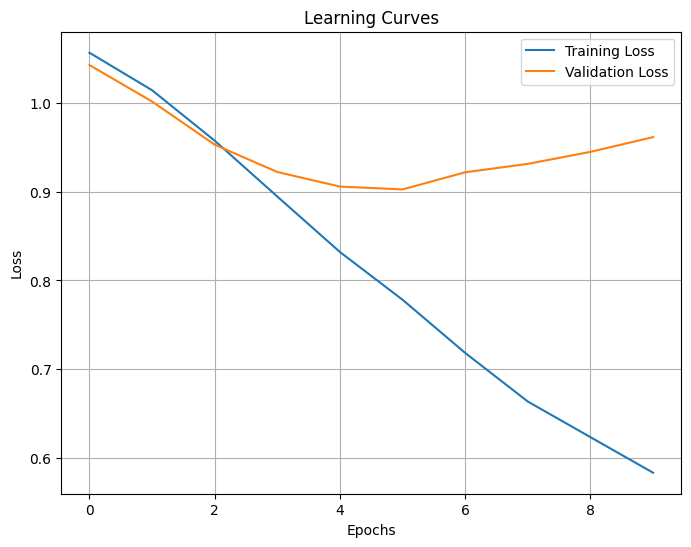

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def predict_and_save_with_texts(model, dataloader, texts, output_csv, threshold=0.5):
    """
    Predicts binary labels using the T5 model, processes logits into probabilities, and saves the results to a CSV.
    
    Args:
        model (torch.nn.Module): The T5 model.
        dataloader (DataLoader): DataLoader for the validation set.
        texts (list): List of original texts corresponding to the validation set.
        output_csv (str): Path to save the predictions.
        threshold (float): Threshold for converting probabilities to binary labels.
    
    Returns:
        None
    """
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            (input_ids, attention_mask), labels = batch

            # Move tensors to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)
            
            # Store binary predictions and true labels
            binary_preds = (probs > threshold).int()
            predictions.append(binary_preds.cpu())
            true_labels.append(labels.cpu())
    
    preds = torch.cat(predictions)  # Binary predictions
    targs = torch.cat(true_labels)  # True labels

    results_df = pd.DataFrame({
        "Text": texts,
        "True Labels": [list(map(int, x)) for x in targs.numpy()],
        "Predicted Labels": [list(map(int, x)) for x in preds.numpy()]
    })

    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")


In [15]:
validation_texts = valid_data["text"].tolist()
output_csv = "results/validation_predictions_with_texts.csv"

# Call the function
predict_and_save_with_texts(
    model=model, 
    dataloader=valid_loader, 
    texts=validation_texts, 
    output_csv=output_csv
)

Generating Predictions:   0%|          | 0/44 [00:00<?, ?it/s]

Generating Predictions: 100%|██████████| 44/44 [01:13<00:00,  1.66s/it]

Predictions saved to results/validation_predictions_with_texts.csv
